In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
# Load Dataset
df_test = pd.read_csv("E:/Mini_project_datasets/test_separated.csv")
df_train = pd.read_csv("E:/Mini_project_datasets/train_separated.csv")


In [3]:
# Function to clean up text
def processed_comments(df, text_column):
    not_alphanumeric = re.compile(r'[\W]')
    not_ascii = re.compile(r'[^a-z0-1\s]')
    
    processed_comments = []
    for comment in df[text_column]:
        lower = comment.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)
    
    df["processed_comments"] = processed_comments
    return df

df_test = processed_comments(df_test, "comment")
df_train = processed_comments(df_train, "comment")


In [4]:
# Define parameters
max_words = 1000
max_sequence_length = 100

In [10]:
# Model creation: Hybrid CNN-Bi-LSTM

# Define the input layer explicitly
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Encoding layer using TextVectorization
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(df_train["processed_comments"].map(lambda text: text))
encoded_input = encoder(input_layer)

# Embedding layer
embedding_layer = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)(encoded_input)

# Convolutional layer
conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)

# Reshape the output of the convolutional layer to add a third dimension
reshaped_conv_layer = tf.keras.layers.Reshape((-1, conv_layer.shape[-1]))(conv_layer)

# Bi-LSTM layer
lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(pooling_layer)
lstm_layer = Bidirectional(LSTM(16))(lstm_layer)

# Define a Lambda layer to add a timestep dimension
add_timestep_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

# Reshape lstm_layer to add a timestep dimension
reshaped_lstm_layer = add_timestep_dim(lstm_layer)

# Concatenating CNN and Bi-LSTM output
concatenated = Concatenate()([GlobalMaxPooling1D()(reshaped_conv_layer), GlobalMaxPooling1D()(reshaped_lstm_layer)])

# Dense layers
dense_layer = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1)(dense_layer)

# Define the model
hybrid_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Summary of the model
hybrid_model.summary()

# Compile the model
hybrid_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=Adam(),
    metrics=['accuracy']
)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_train["processed_comments"].values, df_train["label"], test_size=0.2, random_state=42)

# Training the model
history = hybrid_model.fit(
    x=X_train,
    y=y_train,
    epochs=5,
    validation_data=(X_val, y_val)
)


C:\Users\2111s\anaconda3\Lib\site-packages\keras\src\layers\layer.py:857: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_vectorization_5          │ (None, None)              │               0 │ input_layer_5[0][0]        │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_5 (Embedding)       │ (None, None, 64)          │         640,000 │ text_vectorization_5[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, None, 64)          │          12,352 │ embedding_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_5               │ (None, None, 64)          │               0 │ conv1d_5[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_10              │ (None, None, 64)          │          24,832 │ max_pooling1d_5[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_11              │ (None, 32)                │          10,368 │ bidirectional_10[0][0]     │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_4 (Reshape)           │ (None, None, 64)          │               0 │ conv1d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 1, 32)             │               0 │ bidirectional_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_6        │ (None, 64)                │               0 │ reshape_4[0][0]            │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_7        │ (None, 32)                │               0 │ lambda[0][0]               │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 96)                │               0 │ global_max_pooling1d_6[0]… │
│                               │                           │                 │ global_max_pooling1d_7[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           6,208 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              6

 Total params: 693,825 (2.65 MB)

 Trainable params: 693,825 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 1330s 50ms/step - accuracy: 0.9038 - loss: 0.2188 - val_accuracy: 0.9404 - val_loss: 0.1674
Epoch 2/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 1358s 52ms/step - accuracy: 0.9482 - loss: 0.1351 - val_accuracy: 0.9450 - val_loss: 0.1483
Epoch 3/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 1417s 54ms/step - accuracy: 0.9589 - loss: 0.1112 - val_accuracy: 0.9448 - val_loss: 0.1516
Epoch 4/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 1372s 52ms/step - accuracy: 0.9675 - loss: 0.0910 - val_accuracy: 0.9388 - val_loss: 0.1579
Epoch 5/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 1456s 56ms/step - accuracy: 0.9739 - loss: 0.0767 - val_accuracy: 0.9421 - val_loss: 0.1702


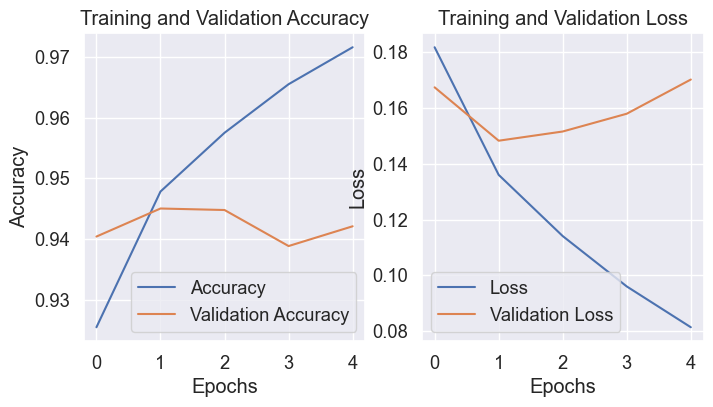

In [12]:
# Plotting the accuracy and loss over time
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step


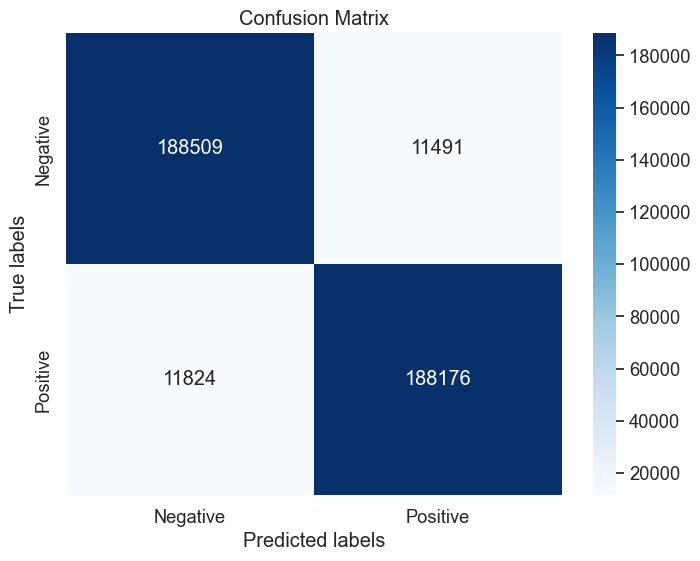

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    200000
           1       0.94      0.94      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



In [11]:
# Evaluating the model on the test set
y_pred = hybrid_model.predict(df_test["processed_comments"].values)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generating confusion matrix
cm = confusion_matrix(df_test["label"], y_pred_classes)

# Displaying confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification Report
report = classification_report(df_test["label"], y_pred_classes)
print("Classification Report:")
print(report)